In [1]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def convert_txt_to_csv(folder_path, target_csv_folder):
    if not os.path.exists(target_csv_folder):
        os.makedirs(target_csv_folder)

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            txt_file_path = os.path.join(folder_path, filename)

            # Define the path for the corresponding CSV file
            csv_file_path = os.path.join(target_csv_folder, filename.replace('.txt', '.csv'))

            if os.path.exists(csv_file_path):
                continue  # Skip to the next file

            try:
                dataframe = pd.read_csv(txt_file_path, delimiter=",")

                dataframe.to_csv(csv_file_path, index=False)
                print(f"Converted {filename} to CSV and saved in {target_csv_folder}.")
            except Exception as e:
                continue

In [4]:
# stocks_folder = "Data/Stocks"
# etfs_folder = "Data/ETFs"
# stocks_csv_folder = "Data/Stocks_csv"
# etfs_csv_folder = "Data/ETFs_csv"

# convert_txt_to_csv(stocks_folder, stocks_csv_folder)
# convert_txt_to_csv(etfs_folder, etfs_csv_folder)

# Constellation Software Stock Prediction

In [5]:
data = pd.read_csv('/home/anjan/Documents/ML/Proj/Data/Stocks_csv/csu.us.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3201 non-null   object 
 1   Open     3201 non-null   float64
 2   High     3201 non-null   float64
 3   Low      3201 non-null   float64
 4   Close    3201 non-null   float64
 5   Volume   3201 non-null   int64  
 6   OpenInt  3201 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 175.2+ KB
None


In [6]:
print(data.describe())

              Open         High          Low        Close        Volume  \
count  3201.000000  3201.000000  3201.000000  3201.000000  3.201000e+03   
mean     12.819691    13.015868    12.614544    12.819516  1.570864e+05   
std       7.042918     7.109862     6.977806     7.039915  1.652596e+05   
min       2.060000     2.340000     1.940000     2.030000  1.700000e+03   
25%       7.270000     7.460000     7.110000     7.300000  5.679800e+04   
50%      10.290000    10.450000    10.150000    10.290000  1.090390e+05   
75%      19.030000    19.350000    18.710000    19.070000  1.989380e+05   
max      27.580000    27.900000    27.090000    27.500000  1.836610e+06   

       OpenInt  
count   3201.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  


In [7]:
null = data.isnull().sum()
print(null)
if null.any() > 0:
    data = data.dropna()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


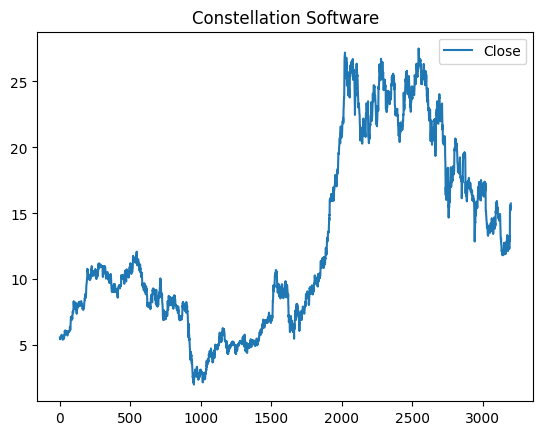

In [8]:
data[['Close']].plot()
plt.title("Constellation Software")
plt.show()

Text(0.5, 1.0, 'Constellation Software Autocorrelation plot')

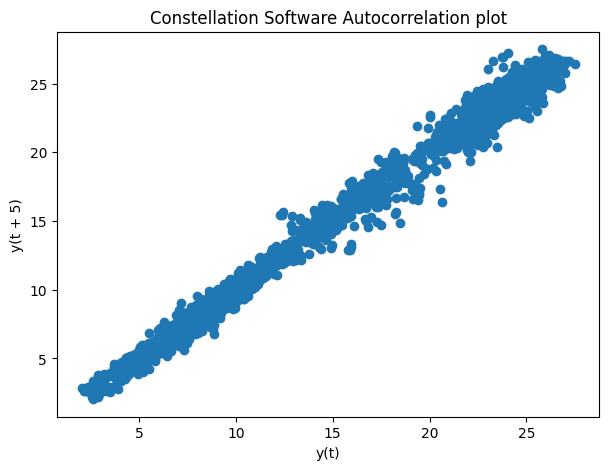

In [9]:
plt.figure(figsize=(7,5))
lag_plot(data['Close'], lag=5)
plt.title('Constellation Software Autocorrelation plot')

In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

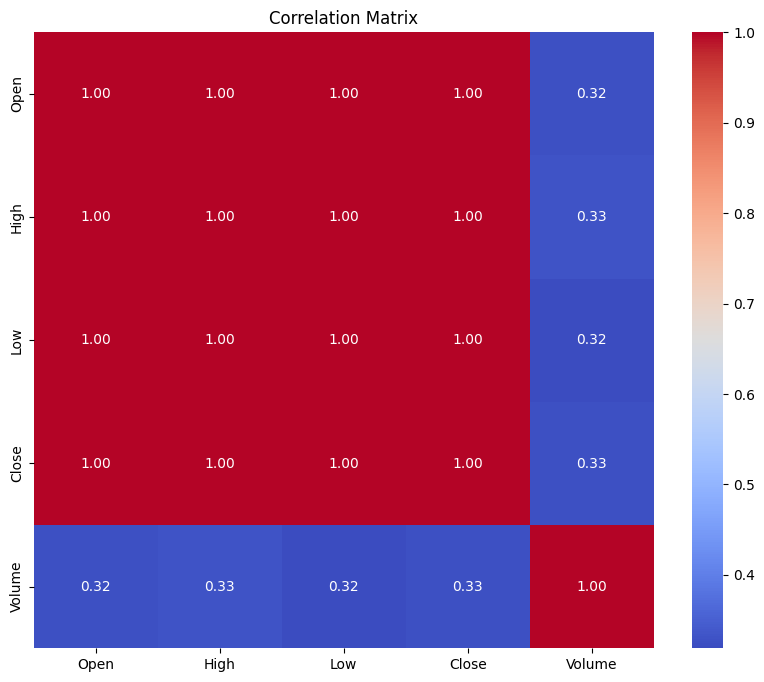

In [11]:
import seaborn as sns

numeric_data = data.drop(columns=['OpenInt'])  # Drop 'OpenInt' if not useful, adjust as needed

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [12]:
# Select relevant features (Close and Volume)
data = data[['Close', 'Volume']]
data.dropna(inplace=True)

In [13]:
# Feature Engineering: Create lag features
for i in range(1, 6):  # Lag features for the last 5 days
    data[f'lag_{i}'] = data['Close'].shift(i)

# Calculate Simple Moving Average (SMA)
data['SMA'] = data['Close'].rolling(window=10).mean()

# Calculate Exponential Moving Average (EMA)
data['EMA'] = data['Close'].ewm(span=10, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

data.dropna(inplace=True)  # Remove NaNs after feature creation

In [14]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    X = np.array(X)
    y = np.array(y)

    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # Split indices based on the test size
    test_size_count = int(len(X) * test_size)
    test_indices = indices[:test_size_count]
    train_indices = indices[test_size_count:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


In [15]:
# Split data into features (X) and target variable (y)
X = data.drop('Close', axis=1)
y = data['Close']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model

In [16]:
class linear_regression:
    def __init__(self, learning_rate=0.0001, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.w = None
        self.b = None

    def fit(self, X, y):
        # Check for NaN or infinite values in data
        if np.any(np.isnan(X)) or np.any(np.isnan(y)):
            print("NaN detected in the data.")
            return

        n_samples, n_features = X.shape

        # Initialize weights and bias with small random values
        self.w = np.random.randn(n_features) * 0.01
        self.b = 0

        # Gradient Descent
        for epoch in range(self.epochs):
            y_pred = np.dot(X, self.w) + self.b

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))  # Gradient for weights
            db = (1 / n_samples) * np.sum(y_pred - y)  # Gradient for bias

            # Clip gradients to avoid exploding gradients
            dw = np.clip(dw, -1.0, 1.0)
            db = np.clip(db, -1.0, 1.0)

            # Update weights and bias
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.w) + self.b  # Linear prediction: y = Xw + b


In [17]:
def root_mean_squared_error(y_true, y_pred):
    squared_errors = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(squared_errors))

def mean_absolute_error(y_true, y_pred):
    absolute_errors = np.abs(y_true - y_pred)
    return np.mean(absolute_errors)

In [18]:
lr_model = linear_regression(learning_rate=0.0001, epochs=100)
lr_model.fit(X_train, y_train)

# Make predictions on the test data
lr_predictions = lr_model.predict(X_test)

# Evaluating the model

lr_mse = root_mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
print(f'Linear Regression RMSE: {lr_mse:.2f}, MAE: {lr_mae:.2f}')

Linear Regression RMSE: 9.46, MAE: 7.61


# Autoregressive Integrated Moving Average (ARIMA)

In [19]:
class ARIMA:
    def __init__(self, p, d, q, learning_rate, epochs):
        self.p = p
        self.d = d
        self.q = q
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.phi = None  # AR coefficients
        self.theta = None  # MA coefficients
        self.bias = None

    def difference(self, series, d):
        # Apply differencing to make series stationary
        for _ in range(d):
            series = np.diff(series, n=1)
        return series

    def inverse_difference(self, original, differenced, d):
        # Revert differencing to restore original scale
        for _ in range(d):
            restored = [original[0]]
            for val in differenced:
                restored.append(restored[-1] + val)
            differenced = restored
        return restored

    def fit(self, series):
        # Train ARIMA model on the given series.
        stationary_series = self.difference(series, self.d) # Differencing

        self.phi = np.zeros(self.p)
        self.theta = np.zeros(self.q)
        self.bias = 0

        # Gradient Descent to optimize coefficients
        errors = []
        residuals = np.zeros(len(stationary_series))  # Convert residuals to numpy array for element-wise operations

        for epoch in range(self.epochs):
            for t in range(max(self.p, self.q), len(stationary_series)):
                # AR component
                ar_part = np.dot(self.phi, stationary_series[t - self.p:t][::-1])

                # MA component
                ma_part = np.dot(self.theta, residuals[t - self.q:t][::-1]) if t >= self.q else 0

                prediction = self.bias + ar_part + ma_part

                # Residual (error)
                error = stationary_series[t] - prediction

                # Update residuals
                residuals[t] = error

                # Update coefficients (Gradient Descent)
                self.phi += self.learning_rate * error * stationary_series[t - self.p:t][::-1]

                if t >= self.q:  # Update MA terms only if sufficient residuals are available
                    self.theta += self.learning_rate * error * residuals[t - self.q:t][::-1]
                self.bias += self.learning_rate * error

            # Store error for monitoring
            mse = np.mean(np.square(residuals[max(self.p, self.q):]))
            errors.append(mse)

            # Stop early if error converges
            if epoch > 1 and abs(errors[-1] - errors[-2]) < 1e-6:
                break

    def forecast(self, series, steps=1):
        # Differencing the series
        stationary_series = self.difference(series, self.d)
        residuals = np.zeros(len(stationary_series))  # Initialize residuals with zeros

        # Generate forecasts
        predictions = []
        for _ in range(steps):
            # Autoregression (AR) component
            ar_part = np.dot(self.phi, stationary_series[-self.p:][::-1]) if len(stationary_series) >= self.p else 0

            # Moving Average (MA) component (only if q > 0)
            if self.q > 0:
                ma_part = np.dot(self.theta, residuals[-self.q:][::-1]) if len(residuals) >= self.q else 0
            else:
                ma_part = 0  # No MA component if q=0

            # Combine components
            prediction = self.bias + ar_part + ma_part

            # Append prediction and update arrays
            predictions.append(prediction)
            stationary_series = np.append(stationary_series, prediction)  # Append prediction to series
            residuals = np.append(residuals, 0)  # Append a zero residual (future unknown)

        # Revert differencing to restore the original scale
        predictions = self.inverse_difference(series, predictions[:steps], self.d)
        return predictions

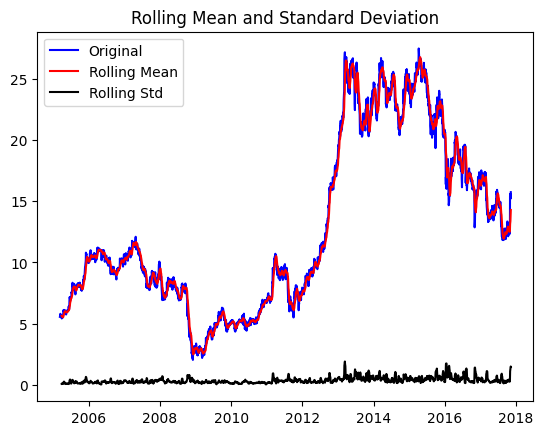

In [20]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

test_stationarity(data['Close'])

In [21]:
data_series = data['Close'].values
train_data = data_series[:int(len(data_series) * 0.8)]
test_data = data_series[int(len(data_series) * 0.8):]

arima_model = ARIMA(p=5, d=1, q=0, learning_rate=0.001, epochs=100)
arima_model.fit(train_data)

predictions = arima_model.forecast(train_data, steps=len(test_data))

if len(predictions) > len(test_data):
    predictions = predictions[:len(test_data)]
elif len(predictions) < len(test_data):
    test_data = test_data[:len(predictions)]

# Evaluate the model
mse = root_mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
print(f'ARIMA RMSE: {lr_mse:.2f}, MAE: {lr_mae:.2f}')

ARIMA RMSE: 9.46, MAE: 7.61


# Microsoft Stock Prediction using ARIMA (Inbuilt)

In [22]:
df = pd.read_csv("/home/anjan/Documents/ML/Proj/Data/Stocks_csv/msft.us.csv")
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


In [23]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

In [24]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [25]:
from statsmodels.tsa.arima.model import ARIMA

train_data, test_data = data.iloc[0:int(len(data) * 0.8)], data.iloc[int(len(data) * 0.8):]

train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

# Initialize history with training data
history = list(train_ar)
predictions = []

# Iteratively train and forecast
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5, 1, 0))  # ARIMA order (p, d, q)
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Forecast one step ahead
    yhat = output[0]  # Extract prediction
    predictions.append(yhat)
    obs = test_ar[t]  # Actual observation
    history.append(obs)  # Add observation to history for next iteration

# Calculate evaluation metrics
mse = root_mean_squared_error(test_ar, predictions)
smape = smape_kun(test_ar, predictions)

print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.3f}')


Testing Mean Squared Error: 0.393
Symmetric Mean Absolute Percentage Error (SMAPE): 1.565


# Long Short-Term Memory (LSTM) Model

In [26]:
# Prepare data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Create datasets for LSTM model
def create_lstm_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [27]:
time_step = 60  # Time series window size

# Prepare data for LSTM
scaled_data = scaler.fit_transform(data[['Close']])  # Ensure only 'Close' is scaled
X_lstm, y_lstm = create_lstm_dataset(scaled_data, time_step)

# Reshape input to 3D array [samples, time steps, features]
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

lstm_model = Sequential([
    Input(shape=(X_lstm.shape[1], 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),  # Final LSTM should not return sequences
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer for regression
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(X_lstm[:-100], y_lstm[:-100], batch_size=32, epochs=100, verbose=1)

# Predictions using LSTM model
lstm_predictions = lstm_model.predict(X_lstm[-100:])
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Inverse transform to original scale

# Evaluate LSTM Model
y_test_lstm = scaler.inverse_transform(y_lstm[-100:].reshape(-1, 1))
lstm_mse = root_mean_squared_error(y_test_lstm, lstm_predictions)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_predictions)
print(f'LSTM RMSE: {lstm_mse:.2f}, MAE: {lstm_mae:.2f}')


Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0455
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0028
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0023
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0023
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0021
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0019
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0016
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0018
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0017
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0016
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0014
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0011
Epoch 13/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0012
Epoch 14/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0012
Epoch 15/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/st